# Large-area metalens

<!--  ![image.png =10x](img/metalens_drawing.png) -->
<!--  <img src="./img/metalens_drawing.png" alt="drawing" width="1000"/> -->

View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=d226dea4-9a65-4481-83d0-7f7d4cbfd388).

## Introduction

Here we use Tidy3D to simulate a very large dielectric metalens.   We base this example off of the recent paper from Khorasaninejad et al. titled [_Metalenses at visible wavelengths: Diffraction-limited focusing and subwavelength resolution imaging_](https://science.sciencemag.org/content/352/6290/1190), which was recently published in Science.  In this paper, a 2-dimensional array of dielectric structures is used as a lens to focus transmitted light to a single position directly above the device.

Typically, these structures are simulated by simulating each dielectric unit cell individually to compute a phase and amplitude transmittance for each cell.  While this approach makes for an approximation of the overall device performance, it would be useful to be able to simulate the *entire* device as a whole to capture the entire physics.  However, a simulation of this scale requires several hours or days to do with a conventional CPU-based FDTD.  With Tidy3D, we are able to complete the entire simulation in about 1 minute!

First, we'll show a simple approach for computing fields on the focal plane by simply placing a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) at the focal plane to record the fields. However, the focal plane is several wavelengths away from the structure, which means that the above setup will involve simulating fields propagating through lots of empty space. Therefore, we will also show how one can instead record the near fields on a large surface just above the structure, and then project them to the focal plane without actually simulating the fields in the empty region in between, leading to a further improvement in the already-impressive simulation speed.

## Setup

We first perform basic imports of the packages needed.

In [1]:
# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

[20:01:36] WARNING  This version of Tidy3D was pip installed from the 'tidy3d-beta' repository on   ]8;id=654089;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=492224;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#101\101]8;;\
                    PyPI. Future releases will be uploaded to the 'tidy3d' repository. From now on,                
                    please use 'pip install tidy3d' instead.                                                       

           INFO     Using client version: 1.10.0rc2                                                 ]8;id=135382;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py\__init__.py]8;;\:]8;id=581290;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/__init__.py#116\116]8;;\

## Define Simulation Parameters

We now set the basic parameters that define the metalens.  The following image (taken from the original paper) define the variables describing the unit cell of the metalens.   The angle of each cell (θ) is chosen for maximum focusing effect.  Note that microns are the default spatial unit in Tidy3D.

<!-- ![image.png](img/metalens_diagram.png) -->
 <img src="img/metalens_diagram.png" alt="diagram" width="700"/>

In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 600 * nm

# desired numerical aperture
NA = 0.5

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
W = 85 * nm
L = 410 * nm
H = 600 * nm
S = 430 * nm

# space between bottom PML and substrate (-z)
space_below_sub = 1 * wavelength

# thickness of substrate
thickness_sub = 100 * nm

# side length of entire metalens (um)
side_length = 10

# Number of unit cells in each x and y direction (NxN grid)
N = int(side_length / S)
print(f'for diameter of {side_length:.1f} um, have {N} cells per side')
print(f'full metalens has area of {side_length**2:.1f} um^2 and {N*N} total cells')

# Define material properties at 600 nm
n_TiO2 = 2.40
n_SiO2 = 1.46
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
TiO2 = td.Medium(permittivity=n_TiO2**2)

for diameter of 10.0 um, have 23 cells per side
full metalens has area of 100.0 um^2 and 529 total cells


In [3]:
# using the wavelength in microns, one can use td.C_0 (um/s) to get frequency in Hz
# wavelength_meters = wavelength * meters
f0 = td.C_0 / wavelength

# Compute the domain size in x, y (note: round down from side_length)
length_xy = N * S

# focal length given diameter and numerical aperture
f = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# Function describing the theoretical best angle of each box at position (x,y).  see paper for details
def theta(x, y):
    return np.pi / wavelength * (f - np.sqrt(x ** 2 + y ** 2 + f ** 2))

# total domain size in z: (space -> substrate -> unit cell -> 1.7 focal lengths)
length_z = space_below_sub + thickness_sub + H + 1.7 * f

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Metalens Geometry

Now we can automatically generate a large metalens structure using these parameters.

We will first create the substrate as a [td.Box](_autosummary/tidy3d.Box.html#tidy3d-box)

Then, we will loop through the x and y coordinates of the lens and create each unit cell as a [td.PolySlab](_autosummary/tidy3d.PolySlab.html#tidy3d-polyslab)

In [4]:
# define substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -length_z/2 + space_below_sub + thickness_sub / 2.0],
        size=[td.inf, td.inf, thickness_sub],
    ),
    medium=SiO2
)

# define coordinates of each unit cell
centers_x = S * np.arange(N) - length_xy / 2.0 + S / 2.0
centers_y = S * np.arange(N) - length_xy / 2.0 + S / 2.0
center_z = -length_z/2 + space_below_sub + thickness_sub + H / 2.0

# x, y vertices of box of size (L, W) centered at the origin
vertices_origin = np.array([[+L/2, +W/2],
                            [-L/2, +W/2],
                            [-L/2, -W/2],
                            [+L/2, -W/2]])


xs, ys = np.meshgrid(centers_x, centers_y, indexing='ij')
xs = xs.flatten()
ys = ys.flatten()

angles = theta(xs, ys)

# 2x2 rotation matrix angle `angle` with respect to x axis
rotation_matrix = np.array([
    [+np.cos(angles), -np.sin(angles)],
    [+np.sin(angles), +np.cos(angles)]
])

# rotate the origin vertices by this angle
vertices_rotated = np.einsum('ij, jkn -> nik', vertices_origin, rotation_matrix)

# shift the rotated vertices to be centered at (xs, ys)
vertices_shifted = vertices_rotated + np.stack([xs, ys], axis=-1)[:, None, :]

metalens_geometry = []
for vertices in vertices_shifted:
    # create a tidy3D PolySlab with these rotated and shifted vertices and thickness `H`
    metalens_geometry.append(
        td.PolySlab(
            vertices=vertices.tolist(),
            slab_bounds=(center_z-H/2, center_z+H/2),
            axis=2,
        ),
    )

metalens = td.Structure(
    geometry=td.GeometryGroup(geometries=metalens_geometry),
    medium=TiO2
)


## Define grid specification

We define the grid based on the properties of the geometry. The metalens is quasi-periodic in x and y, in that we have clearly defined unit cells, but each is slightly modified from its neighbors. Such structures are best resolved with a grid that matches the periodicity, which is why we use a uniform grid in x and y. In z, we use the automatic nonuniform grid that will place a higher grid density around the metalens region, and a lower one in the air region away from the metalens. To speed up the auto meshing in the region with the pillars, we put an override box in the grid specification.

In [5]:
# steps per unit cell along x and y
grids_per_unit_length = 20
# uniform mesh in x and y
grid_x = td.UniformGrid(dl=S / grids_per_unit_length)
grid_y = td.UniformGrid(dl=S / grids_per_unit_length)
# in z, use an automatic nonuniform mesh with the wavelength being the "unit length"
grid_z = td.AutoGrid(min_steps_per_wvl=grids_per_unit_length)
# we need to supply the wavelength because of the automatic mesh in z
grid_spec = td.GridSpec(wavelength=wavelength, grid_x=grid_x, grid_y=grid_y, grid_z=grid_z)
# put an override box over the pillars to avoid parsing a large amount of structures in the mesher
grid_spec = grid_spec.copy(update=dict(override_structures = [
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-td.inf, -td.inf, -length_z/2 + space_below_sub),
            rmax=(td.inf, td.inf, center_z + H/2)
        ),
        medium=TiO2,
    )
]))

## Define Sources

Now we define the incident fields.  We simply use a normally incident plane wave with Guassian time dependence centered at our central frequency.  For more details, see the [plane wave source documentation](_autosummary/tidy3d.PlaneWave.html#tidy3d-planewave) and the [gaussian source documentation](_autosummary/tidy3d.GaussianPulse.html#tidy3d-gaussianpulse)

In [6]:
# Bandwidth in Hz
fwidth = f0 / 10.0

# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0,0,-length_z/2 + space_below_sub / 10.0),
    direction='+',
    pol_angle=0)

run_time = 50 / fwidth

## Define Monitors

Now we define the monitors that measure field output from the FDTD simulation.  For simplicity, we use measure the fields at the central frequency.  We'll get the fields at the following locations:

- The y=0 cross section
- The x=0 cross section
- The z=f cross section at the focal plane
- The central axis, along x=y=0

For more details on defining monitors, see the [frequency-domain field monitor documentation](../_autosummary/tidy3d.FieldMonitor.html).

In [7]:
# To decrease the amount of data stored, only store the E field in 2D monitors
fields = ["Ex", "Ey", "Ez"]

# get fields along x=y=0 axis
monitor_center = td.FieldMonitor(
    center=[0., 0., 0],
    size=[0, 0, td.inf],
    freqs=[f0],
    name='center'
)

# get the fields at a few cross-sectional planes
monitor_xz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[td.inf, 0., td.inf],
    freqs=[f0],
    name='xz',
    fields=fields,
)

monitor_yz = td.FieldMonitor(
    center=[0., 0., 0.],
    size=[0., td.inf, td.inf],
    freqs=[f0],
    name='yz',
    fields=fields,
)

monitor_xy = td.FieldMonitor(
    center=[0., 0., center_z + H/2 + f],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='focal_plane',
    fields=fields,
)

# put them into a single list
monitors=[monitor_center, monitor_xz, monitor_yz, monitor_xy]

## Create Simulation

Now we can put everything together and define a [Simulation](../_autosummary/tidy3d.Simulation.html) object to be run.



We get a number of warnings about structures being too close to the PML. In FDTD simulations, this can result in instability, as PML are absorbing for propagating fields, but can be amplifying for evanescent fields. This particular simulation runs without any issues even with PML on the sides, but it is best to heed these warnings to avoid problems. There are two ways that we can fix the simulation: one is to just put some space between the last of the metalens boxes and the PML. The other is to use adiabatic absorbers on the sides, which are always stable. The only downside of the absorbers is that they are slightly thicker than the PML, making the overall simulation size slighlty larger. This is why we only put them along x and y, while we leave the PML in z.

In [8]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, metalens],
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(),
        y=td.Boundary.absorber(),
        z=td.Boundary.pml()
    )
)

## Visualize Geometry

Lets take a look and make sure everything is defined properly


[20:01:37] WARNING  Override structures take no effect along x-axis. If intending to apply         ]8;id=439756;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=344085;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#548\548]8;;\
                    override structures to this axis, use 'AutoGrid'.                                              

           WARNING  Override structures take no effect along y-axis. If intending to apply         ]8;id=564818;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=217887;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#548\548]8;;\
                    override structures to this axis, use 'AutoGrid'.                                              

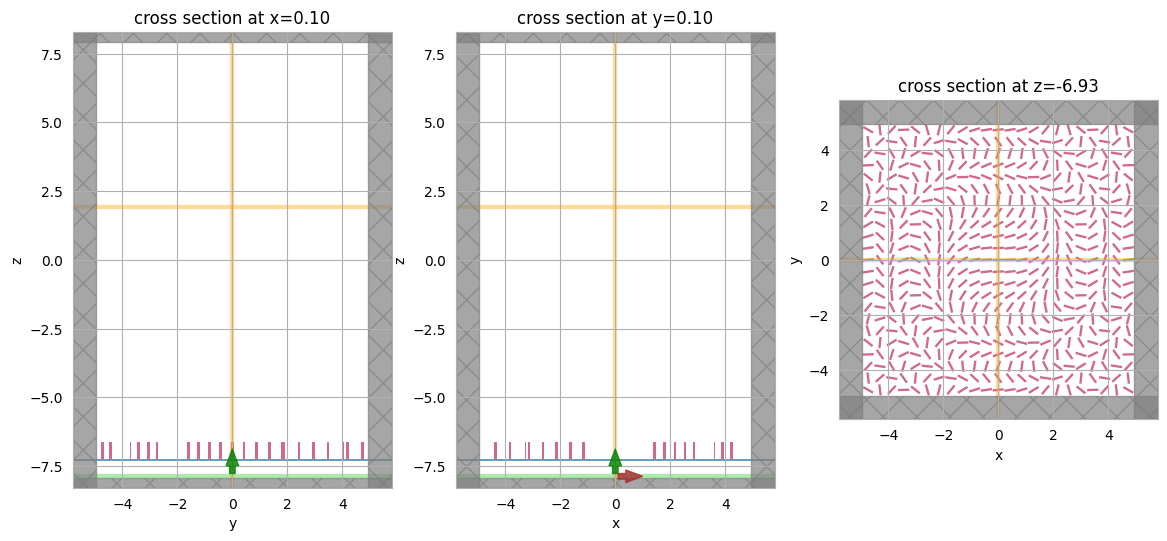

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

sim.plot(x=0.1, ax=ax1);
sim.plot(y=0.1, ax=ax2);
sim.plot(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, ax=ax3);

## Run Simulation

Now we can run the simulation over time and measure the results to plot


In [10]:
job = web.Job(simulation=sim, task_name='metalens')
sim_data = job.run(path='data/simulation_data.hdf5')

[20:01:41] INFO     Created task 'metalens' with task_id                                              ]8;id=788925;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=140640;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#136\136]8;;\
                    'fdve-5575e831-76e8-4bad-b2b4-ae7af18c3cfdv1'.                                                 

Output()

[20:01:48] INFO     status = queued                                                                   ]8;id=112285;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=758059;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#265\265]8;;\

Output()

[20:05:08] INFO     status = preprocess                                                               ]8;id=849154;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=514414;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

[20:05:14] INFO     Maximum FlexUnit cost: 1.631. Use 'web.real_cost(task_id)' to get the billed      ]8;id=37691;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=198908;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#282\282]8;;\
                    FlexUnit cost after a simulation run.                                                          

           INFO     starting up solver                                                                ]8;id=139739;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=721930;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

[20:06:01] INFO     running solver                                                                    ]8;id=156198;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=837416;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#296\296]8;;\

Output()

[20:06:54] INFO     early shutoff detected, exiting.                                                  ]8;id=461296;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=702028;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

[20:06:56] INFO     status = success                                                                  ]8;id=421060;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=760787;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#326\326]8;;\

Output()

[20:10:22] INFO     loading SimulationData from data/simulation_data.hdf5                             ]8;id=25249;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=261566;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#507\507]8;;\

In [11]:
print(sim_data.log)

Simulation domain Nx, Ny, Nz: [541, 541, 589]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.7426e+08.
Using subpixel averaging: True
Number of time steps: 3.1633e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 3.1636e-17


Compute source modes time (s):     0.8141
Compute monitor modes time (s):    0.0059
Rest of setup time (s):            6.8171

Running solver for 31633 time steps...
- Time step    503 / time 1.59e-14s (  1 % done), field decay: 1.00e+00
- Time step   1265 / time 4.00e-14s (  4 % done), field decay: 1.00e+00
- Time step   2530 / time 8.00e-14s (  8 % done), field decay: 1.25e-01
- Time step   3795 / time 1.20e-13s ( 12 % done), field decay: 5.74e-03
- Time step   5061 / time 1.60e-13s ( 16 % done), field decay: 9.60e-04
- Time step   6326 / time 2.00e-13s ( 20 % done), field decay: 1.84e-04
- Time step   7591 / time 2.40e-13s ( 24 % done), field decay: 4.23e-05
- Time step   8857 / time 2.80e-13s ( 28 % done), field decay: 1.31e-05
- Time

----

As we can see from the logs, the **total time to solve this problem (not including data transfer and pre/post-processing) was on the order of a minute!**

For reference, the same problem run with FDTD on a **single CPU core FDTD is projected to take 40 hours!**

## Visualize Fields

Let's see the results of the simulation as captured by our field monitors.

First, we look at the field intensity along the axis of the lens

           WARNING  Override structures take no effect along x-axis. If intending to apply         ]8;id=983889;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=261188;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#548\548]8;;\
                    override structures to this axis, use 'AutoGrid'.                                              

           WARNING  Override structures take no effect along y-axis. If intending to apply         ]8;id=839716;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=776080;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#548\548]8;;\
                    override structures to this axis, use 'AutoGrid'.                                              

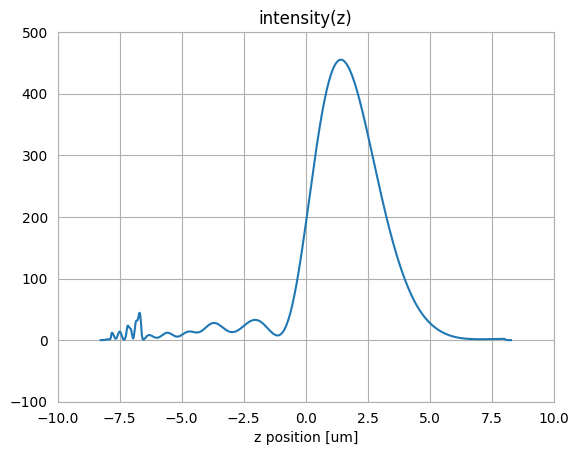

In [12]:
focal_z = center_z+H/2+f
data_center_line = sim_data.at_centers('center')
I = abs(data_center_line.Ex)**2 + abs(data_center_line.Ey)**2 + abs(data_center_line.Ez)**2
I.plot()
plt.title('intensity(z)')
plt.show()

We now can inspect the field patterns on the area monitors using the Tidy3D visualization nethods.

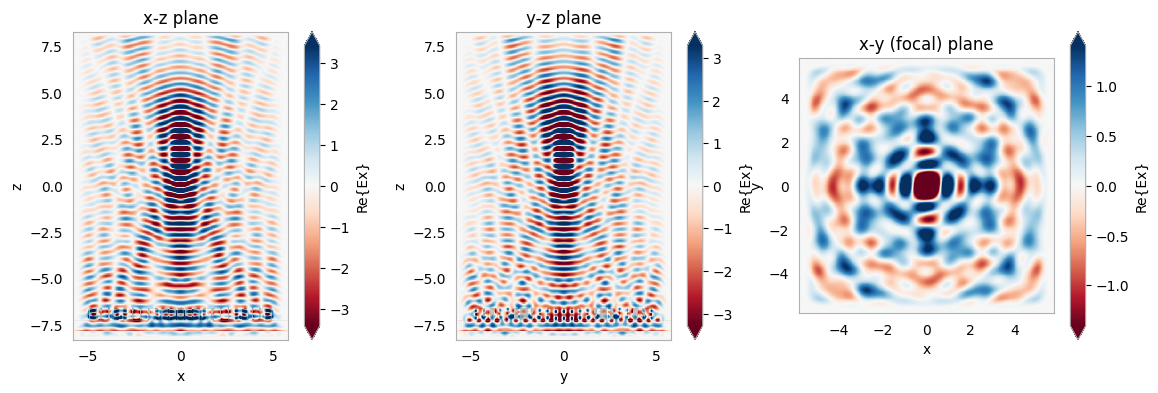

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sim_data.plot_field('xz', 'Ex', val='real', f=f0, y=0, ax=ax1)
sim_data.plot_field('yz', 'Ex', val='real', f=f0, x=0, ax=ax2)
sim_data.plot_field('focal_plane', 'Ex', val='real', f=f0, z=focal_z, ax=ax3)
ax1.set_title('x-z plane')
ax2.set_title('y-z plane')
ax3.set_title('x-y (focal) plane')
plt.show()

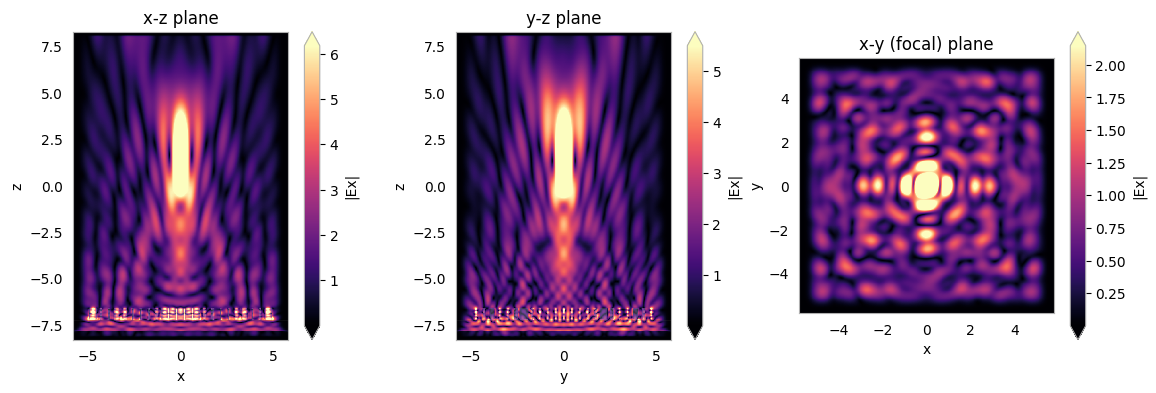

In [14]:
# plot absolute value for good measure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sim_data.plot_field('xz', 'Ex', val='abs', f=f0, y=0, ax=ax1)
sim_data.plot_field('yz', 'Ex', val='abs', f=f0, x=0, ax=ax2)
sim_data.plot_field('focal_plane', 'Ex', val='abs', f=f0, z=focal_z, ax=ax3)
ax1.set_title('x-z plane')
ax2.set_title('y-z plane')
ax3.set_title('x-y (focal) plane')
plt.show()

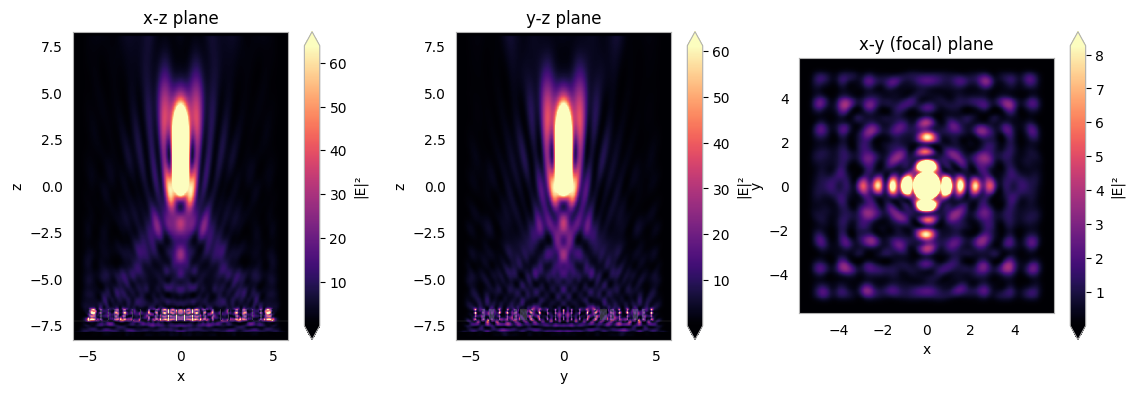

In [15]:
# and let's plot the intensites as well
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
sim_data.plot_field('xz', 'E', 'abs^2', f=f0, y=0, ax=ax1)
sim_data.plot_field('yz', 'E', 'abs^2', f=f0, x=0, ax=ax2)
sim_data.plot_field('focal_plane', 'E', 'abs^2', f=f0, z=focal_z, ax=ax3)
ax1.set_title('x-z plane')
ax2.set_title('y-z plane')
ax3.set_title('x-y (focal) plane')
plt.show()

## Field Projection to the Focal Plane
Here we'll show how to avoid simulating lots of empty space above the structure by using `Tidy3D`'s field projection functionality.

[20:10:43] WARNING  Override structures take no effect along x-axis. If intending to apply         ]8;id=854523;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=843750;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#548\548]8;;\
                    override structures to this axis, use 'AutoGrid'.                                              

           WARNING  Override structures take no effect along y-axis. If intending to apply         ]8;id=272726;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=411588;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#548\548]8;;\
                    override structures to this axis, use 'AutoGrid'.                                              

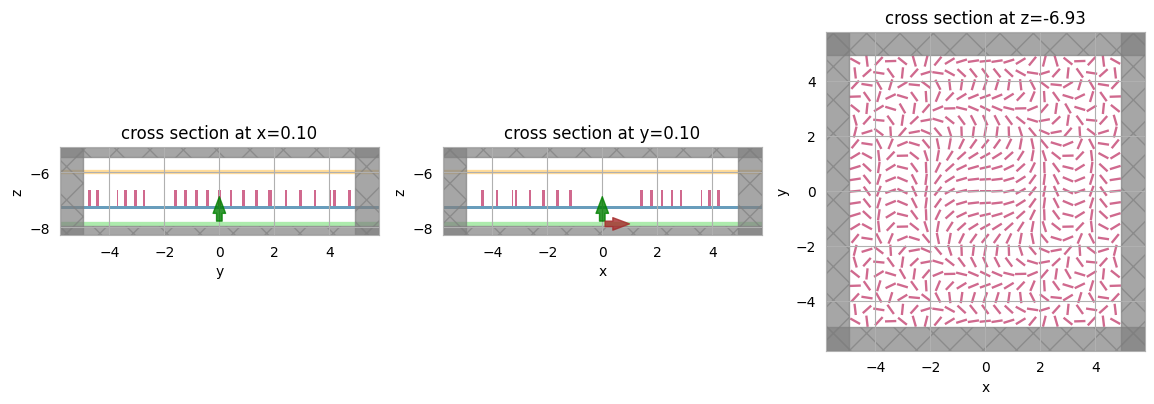

In [16]:
# create a field projection monitor in Cartesian coordinates which records near fields just above the strucure,
# and projects them to points on the focal plane

# number of focal plane sampling points in the x and y directions
num_far = 200

# define the focal plane sample points at which to project fields
xs_far = np.linspace(-sim_size[0] / 2, sim_size[0] / 2, num_far)
ys_far = np.linspace(-sim_size[1] / 2, sim_size[1] / 2, num_far)

pos_monitor_z = -6
proj_distance = monitor_xy.center[2] - pos_monitor_z
monitor_proj = td.FieldProjectionCartesianMonitor(
    center=[0., 0., pos_monitor_z],
    size=[td.inf, td.inf, 0],
    freqs=[f0],
    name='focal_plane_proj',
    proj_axis=2,           # axis along which to project, in this case z
    proj_distance=proj_distance, # distance from this monitor to where fields are projected
    x=xs_far,
    y=ys_far,
    custom_origin=[0., 0., pos_monitor_z],
    far_field_approx=False, # the distance to the focal plane is comparable to the size of the structure, so
                            # turn off the far-field approximation and use an exact Green's function to
                            # project the fields
)

# create a simulation as before, but this time there's no need to include the large amount of 
# empty space up to the focal plane, and include the projection monitor

# total domain size in z: (space -> substrate -> unit cell -> space)
length_z_new = space_below_sub + thickness_sub + 2 * H + space_below_sub
sim_size = (length_xy, length_xy, length_z_new)
sim_center = (0, 0, -length_z / 2 + length_z_new / 2)
sim_new = td.Simulation(
    size=sim_size,
    center=sim_center,
    grid_spec=grid_spec,
    structures=[substrate, metalens],
    sources=[source],
    monitors=[monitor_proj],
    run_time=run_time,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.absorber(),
        y=td.Boundary.absorber(),
        z=td.Boundary.pml()
    )
)

# visualize to make sure everything looks okay
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))
sim_new.plot(x=0.1, ax=ax1);
sim_new.plot(y=0.1, ax=ax2);
sim_new.plot(z=-length_z/2 + space_below_sub + thickness_sub + H / 2, ax=ax3);

## Run
Run the new simulation and note the simulation time recorded in the log.

In [17]:
job = web.Job(simulation=sim_new, task_name='metalens')
sim_data_new = job.run(path='data/simulation_data_new.hdf5')
print(sim_data_new.log)

[20:10:46] INFO     Created task 'metalens' with task_id                                              ]8;id=163799;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=908108;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#136\136]8;;\
                    'fdve-d8826c35-ac8c-4396-8f0b-8e68619059c1v1'.                                                 

Output()

[20:10:52] INFO     status = queued                                                                   ]8;id=576000;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=264713;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#265\265]8;;\

Output()

[20:10:57] INFO     status = preprocess                                                               ]8;id=276736;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=384461;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#258\258]8;;\

[20:11:02] INFO     Maximum FlexUnit cost: 0.415. Use 'web.real_cost(task_id)' to get the billed      ]8;id=386618;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=53689;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#282\282]8;;\
                    FlexUnit cost after a simulation run.                                                          

           INFO     starting up solver                                                                ]8;id=15441;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=800069;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#286\286]8;;\

[20:11:14] INFO     running solver                                                                    ]8;id=378725;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=191311;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#296\296]8;;\

Output()

[20:12:40] INFO     early shutoff detected, exiting.                                                  ]8;id=378634;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=469844;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#309\309]8;;\

           INFO     status = postprocess                                                              ]8;id=423388;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=321419;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#326\326]8;;\

Output()

[20:12:44] INFO     status = success                                                                  ]8;id=607497;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=560199;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#333\333]8;;\

Output()

[20:12:49] INFO     loading SimulationData from data/simulation_data_new.hdf5                         ]8;id=155973;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=657602;file:///home/lucas/Flexcompute/dev/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#507\507]8;;\

Simulation domain Nx, Ny, Nz: [541, 541, 144]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 4.3048e+07.
Using subpixel averaging: True
Number of time steps: 3.1633e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 3.1636e-17


Compute source modes time (s):     1.2107
Compute monitor modes time (s):    0.0785
Rest of setup time (s):            12.0157

Running solver for 31633 time steps...
- Time step    503 / time 1.59e-14s (  1 % done), field decay: 1.00e+00
- Time step   1265 / time 4.00e-14s (  4 % done), field decay: 1.30e-01
- Time step   2530 / time 8.00e-14s (  8 % done), field decay: 1.26e-02
- Time step   3795 / time 1.20e-13s ( 12 % done), field decay: 2.13e-03
- Time step   5061 / time 1.60e-13s ( 16 % done), field decay: 4.33e-04
- Time step   6326 / time 2.00e-13s ( 20 % done), field decay: 8.90e-05
- Time step   7591 / time 2.40e-13s ( 24 % done), field decay: 2.04e-05
- Time step   8857 / time 2.80e-13s ( 28 % done), field decay: 7.28e-06
Field

The solver time was reduced by a factor of about 3, and about 10x less data needs to be downloaded compared to the original simulation! Furthermore, only a few seconds (a small fraction of the total time) were spent on projecting the near fields to the focal plane.

## Plot Fields
Finally, let's plot the fields on the focal plane and compare those recorded previously in the large simulation to those computed via field projections just now. Comparing the actual simulated fields to the projected ones, we notice an excellent match, with a several-fold reduction in compute time.

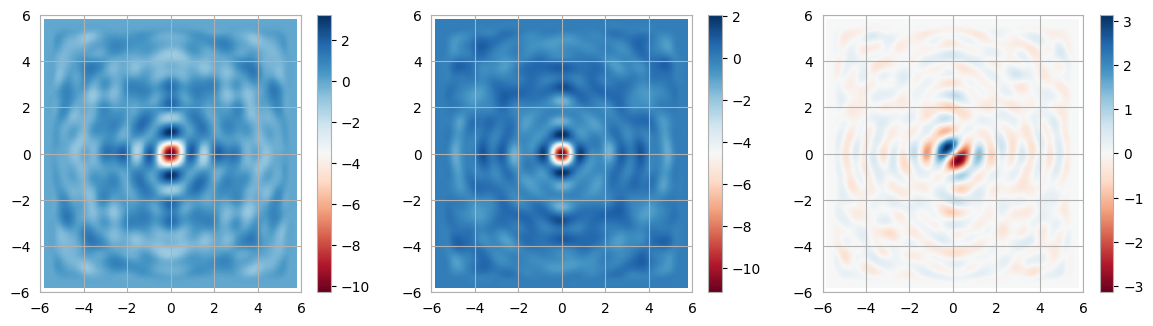

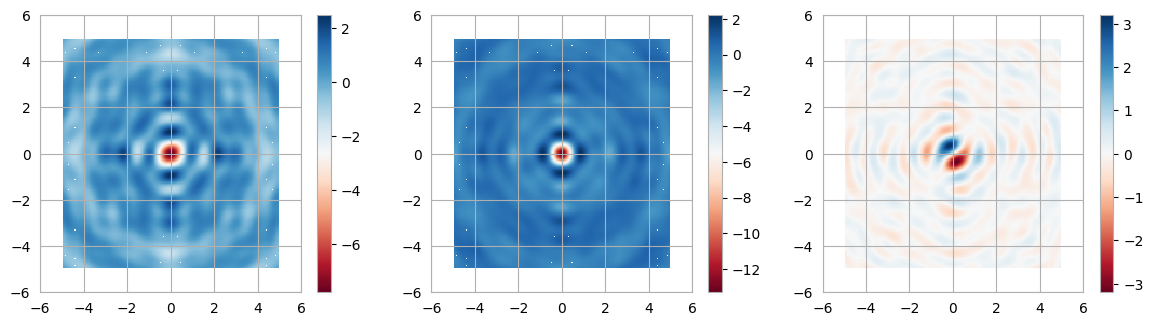

In [18]:
# plot the focal plane electric field components recorded by directly placing a monitor in the first simulation,
# which we can use as a reference
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14.3, 3.6))
focal_field_data = sim_data['focal_plane']
Ex = focal_field_data.Ex.sel(f=f0, z=focal_z)
Ey = focal_field_data.Ey.sel(f=f0, z=focal_z)
Ez = focal_field_data.Ez.sel(f=f0, z=focal_z)
im1 = ax1.pcolormesh(Ex.y, Ex.x, np.real(Ex), cmap='RdBu', shading='auto')
im2 = ax2.pcolormesh(Ey.y, Ey.x, np.real(Ey), cmap='RdBu', shading='auto')
im3 = ax3.pcolormesh(Ez.y, Ez.x, np.real(Ez), cmap='RdBu', shading='auto')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

# now plot the projected fields computed via the second simulation
proj_fields = sim_data_new['focal_plane_proj'].fields_cartesian.sel(f=f0, z=monitor_proj.proj_distance)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14.3, 3.6))
im1 = ax1.pcolormesh(ys_far, xs_far, np.real(proj_fields.Ex), cmap='RdBu', shading='auto')
im2 = ax2.pcolormesh(ys_far, xs_far, np.real(proj_fields.Ey), cmap='RdBu', shading='auto')
im3 = ax3.pcolormesh(ys_far, xs_far, np.real(proj_fields.Ez), cmap='RdBu', shading='auto')
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
